# Gauss elimination with backsubstitution

| Who  | Mail | Date | What |
| ---  | ---   | --- | ---      |
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co>  | May 17th, 2025 | Initial code |

Gaussian elimination with backsubstitution is a fundamental numerical method for solving systems of linear equations. Unlike Gauss-Jordan elimination, which transforms the coefficient matrix into the identity matrix, Gaussian elimination only transforms the matrix into an upper triangular form, followed by a backsubstitution step to find the solution vector.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
import pandas as pd
import time

## 1. Mathematical Background

Consider a system of $n$ linear equations with $n$ unknowns:

$$
\begin{align}
a_{11}x_1 + a_{12}x_2 + \cdots + a_{1n}x_n &= b_1\\
a_{21}x_1 + a_{22}x_2 + \cdots + a_{2n}x_n &= b_2\\
\vdots\\
a_{n1}x_1 + a_{n2}x_2 + \cdots + a_{nn}x_n &= b_n
\end{align}
$$

This system can be represented in matrix form as $\boldsymbol{A}\boldsymbol{x} = \boldsymbol{b}$, where:

$$\boldsymbol{A} = 
\begin{bmatrix} 
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}, 
\quad \boldsymbol{x} = 
\begin{bmatrix} 
x_1 \\
x_2 \\
\vdots \\
x_n
\end{bmatrix}, 
\quad \boldsymbol{b} = 
\begin{bmatrix} 
b_1 \\
b_2 \\
\vdots \\
b_n
\end{bmatrix}
$$

The augmented matrix combines $\boldsymbol{A}$ and $\boldsymbol{b}$:

$$[\boldsymbol{A}|\boldsymbol{b}] = 
\begin{bmatrix} 
a_{11} & a_{12} & \cdots & a_{1n} & b_1 \\
a_{21} & a_{22} & \cdots & a_{2n} & b_2 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn} & b_n
\end{bmatrix}
$$

Gaussian elimination with backsubstitution consists of two main phases:

1. **Forward Elimination**: Transform the augmented matrix $[\boldsymbol{A}|\boldsymbol{b}]$ into an upper triangular form.
2. **Backsubstitution**: Solve for the unknowns starting from the last equation and moving upward.

## 2. Implementation of the Gauss-Jordan elimination method

### 2.1 Visualization Functions

In [2]:
def print_matrix(matrix, precision=4):
    """Pretty print an augmented matrix with colored-blue last column"""
    m, n = matrix.shape
    
    df = pd.DataFrame(np.round(matrix, precision))
    df.index += 1 
    df.columns = [f'A[:,{i}]' for i in range(1, n)] + ['b']
    
    # Adjust the display
    pd.set_option('display.max_columns', None)  # print an unlimited number of columns
    pd.set_option('display.width', None)        # width of the display in characters
    
    # Apply the style to the last column
    def highlight_last_column(s):
        return ['background-color: lightblue' if s.name == df.columns[-1] else '' for _ in s]
    
    return df.style.apply(highlight_last_column, axis=0)

### 2.2 Implementation

### Forward Elimination

The forward elimination phase transforms the augmented matrix into an upper triangular form. The key differences from Gauss-Jordan elimination are:

1. The outer loop runs only to `n-1` (not including the last row).
2. We only eliminate entries below the diagonal (rows `i > j`).
3. We don't normalize the pivot row (the diagonal elements are not necessarily 1).

After this phase, the augmented matrix has a row echelon form:
$$
\begin{bmatrix} 
a_{11}' & a_{12}' & \cdots & a_{1n}' & b_1' \\
0 & a_{22}' & \cdots & a_{2n}' & b_2' \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & a_{nn}' & b_n'
\end{bmatrix}
$$

In [3]:
def gaussian_elimination(A, b, show_steps=False):
    """
    Solve a system of linear equations using Gaussian elimination with backsubstitution.
    
    Parameters:
        A (numpy.ndarray): Coefficient matrix of shape (n, n)
        b (numpy.ndarray): Right-hand side vector of shape (n,)
        show_steps (bool): Whether to print intermediate steps
    
    Returns:
        numpy.ndarray: Augmented matrix in row echelon form (n, n+1)
    """
    # Check if A is square
    n, m = A.shape
    if n != m:
        raise ValueError("Coefficient matrix A must be square")
    
    # Check if b has compatible dimensions
    if len(b) != m:
        raise ValueError("Dimensions of A and b must be compatible")
    
    # Create the augmented matrix [A|b]
    augmented = np.column_stack((A.astype(float), b.astype(float)))
   
    if show_steps:
        print("Initial augmented matrix:")
        display(print_matrix(augmented))
        print("-" * 40)
    
    # Forward elimination
    for j in range(n-1):  # Only go to n-1 as we don't need to eliminate the last row
        # Find the pivot row (row with the largest absolute value in column j)
        pivot_row = j + np.argmax(abs(augmented[j:n, j]))
        # pivot_row = j
        # for i in range(j + 1, n):
        #     if abs(augmented[i, j]) > abs(augmented[pivot_row, j]):
        #          pivot_row = i
        
        # Swap the current row with the pivot row
        if pivot_row != j:
            augmented[[j, pivot_row]] = augmented[[pivot_row, j]]
            if show_steps:
                print(f"Swap rows {j+1} and {pivot_row+1}:")
                display(print_matrix(augmented))
                print("-" * 40)
        
        # Check if matrix is singular
        pivot = augmented[j, j]
        if abs(pivot) < 1e-10:
            raise ValueError("Matrix is singular or nearly singular")
        
        # Eliminate entries below the pivot
        for i in range(j + 1, n):
            factor = augmented[i, j]/pivot
            if abs(factor) > 1e-10:  # Only perform elimination if necessary
                augmented[i] = augmented[i] - factor*augmented[j]
                if show_steps:
                    print(f"Subtract {factor:.4f} times row {j+1} from row {i+1}:")
                    display(print_matrix(augmented))
                    print("-" * 40)
    
    if show_steps:
        print("Upper triangular form:")
        display(print_matrix(augmented))
        print("-" * 40)
    
    # Check if the matrix is singular
    if abs(augmented[n-1, n-1]) < 1e-10:
        raise ValueError("Matrix is singular or nearly singular")
      
    return augmented

### Backsubstitution

The backsubstitution phase solves for the unknowns starting from the last equation and moving upward. Mathematically, we solve:

1. First, $x_n = \frac{b_n'}{a_{nn}'}$
2. Then, for $i = n-1, n-2, \ldots, 1$:
   $$x_i = \frac{b_i' - \sum_{j=i+1}^{n} a_{ij}'x_j}{a_{ii}'}$$

In [4]:
def backsubstitution(augmented):
    """
    Solve a system of linear equations using Gaussian elimination with backsubstitution.
    
    Parameters:
        augmented (numpy.ndarray): Augmented matrix in row echelon form (n, n+1)
    
    Returns:
        numpy.ndarray: Solution vector x of shape (n,)
    """
    n, m = augmented.shape

    if n+1 != m:
        raise ValueError("Augmented matrix must be have size (n, n+1)")
    
    # Views over "augmented" for code clarity
    A = augmented[:, :n]
    b = augmented[:, -1]

    # Backsubstitution
    x = np.zeros(n)
    for i in range(n-1, -1, -1):  # Start from the last row and move upward
        x[i] = (b[i] - np.sum(A[i, i+1:n]*x[i+1:n]))/A[i, i]

    return x

## 3. Examples

### Example 1: Solving a simple 3x3 system

In [5]:
A = np.array([
    [ 2,  1, -1],
    [-3, -1,  2],
    [-2,  7,  2]
])

x = np.array([8, -11, -3])

b = A @ x

print("\nCoefficient matrix A:")
print(A)
print("\nRight-hand side vector b:")
print(b)

print("\nAugmented system:")
print_matrix(np.column_stack((A, b)))


Coefficient matrix A:
[[ 2  1 -1]
 [-3 -1  2]
 [-2  7  2]]

Right-hand side vector b:
[  8 -19 -99]

Augmented system:


,"A[:,1]","A[:,2]","A[:,3]",b
1,2,1,-1,8
2,-3,-1,2,-19
3,-2,7,2,-99


In [6]:
try:
    x = backsubstitution(gaussian_elimination(A, b))
    print("\nSolution using our Gaussian elimination implementation:")
    print(x)
    
    # Verify the solution
    print("\nVerification A*x:")
    print(A@x)
    
    # Compare with NumPy's built-in solver
    x_numpy = np.linalg.solve(A, b)
    print("\nSolution using NumPy's solver:")
    print(x_numpy)
    
    # Check if solutions are close
    print(f"\nOur solution matches NumPy's: {np.allclose(x, x_numpy)}")
    
except ValueError as error:
    print(f"Error: {error}")

# Condition number analysis
cond = np.linalg.cond(A)
print(f"\nCondition number of matrix: {cond:.2f}")
if cond < 100:
    print("The system is well-conditioned.")
else:
    print("The system is poorly conditioned, which may lead to numerical instability.")    


Solution using our Gaussian elimination implementation:
[  8. -11.  -3.]

Verification A*x:
[  8. -19. -99.]

Solution using NumPy's solver:
[  8. -11.  -3.]

Our solution matches NumPy's: True

Condition number of matrix: 36.32
The system is well-conditioned.


In [7]:
x = backsubstitution(gaussian_elimination(A, b, show_steps=True))

Initial augmented matrix:


,"A[:,1]","A[:,2]","A[:,3]",b
1,2.000000,1.000000,-1.000000,8.000000
2,-3.000000,-1.000000,2.000000,-19.000000
3,-2.000000,7.000000,2.000000,-99.000000


----------------------------------------
Swap rows 1 and 2:


,"A[:,1]","A[:,2]","A[:,3]",b
1,-3.000000,-1.000000,2.000000,-19.000000
2,2.000000,1.000000,-1.000000,8.000000
3,-2.000000,7.000000,2.000000,-99.000000


----------------------------------------
Subtract -0.6667 times row 1 from row 2:


,"A[:,1]","A[:,2]","A[:,3]",b
1,-3.000000,-1.000000,2.000000,-19.000000
2,0.000000,0.333300,0.333300,-4.666700
3,-2.000000,7.000000,2.000000,-99.000000


----------------------------------------
Subtract 0.6667 times row 1 from row 3:


,"A[:,1]","A[:,2]","A[:,3]",b
1,-3.000000,-1.000000,2.000000,-19.000000
2,0.000000,0.333300,0.333300,-4.666700
3,0.000000,7.666700,0.666700,-86.333300


----------------------------------------
Swap rows 2 and 3:


,"A[:,1]","A[:,2]","A[:,3]",b
1,-3.000000,-1.000000,2.000000,-19.000000
2,0.000000,7.666700,0.666700,-86.333300
3,0.000000,0.333300,0.333300,-4.666700


----------------------------------------
Subtract 0.0435 times row 2 from row 3:


,"A[:,1]","A[:,2]","A[:,3]",b
1,-3.000000,-1.000000,2.000000,-19.000000
2,0.000000,7.666700,0.666700,-86.333300
3,0.000000,0.000000,0.304300,-0.913000


----------------------------------------
Upper triangular form:


,"A[:,1]","A[:,2]","A[:,3]",b
1,-3.000000,-1.000000,2.000000,-19.000000
2,0.000000,7.666700,0.666700,-86.333300
3,0.000000,0.000000,0.304300,-0.913000


----------------------------------------


### Example 2: Ill-conditioned system

In [8]:
A = np.array([
    [1, 1],
    [1, 1.000000000000000001]
])

b = np.array([2, 2.000000000000000001])

print("\n\nIll-conditioned system")
print("Coefficient matrix A:")
print(A)
print("\nRight-hand side vector b:")
print(b)

try:
    x = backsubstitution(gaussian_elimination(A, b))
    print("\nSolution using our Gaussian elimination implementation:")
    print(x)
    
    # Verify the solution
    print("\nVerification A*x:")
    print(A@x)
    
    # Compare with NumPy's built-in solver
    x_numpy = np.linalg.solve(A, b)
    print("\nSolution using NumPy's solver:")
    print(x_numpy)
    
except ValueError as error:
    print(f"Error: {error}")

# Condition number analysis
cond = np.linalg.cond(A)
print(f"\nCondition number of matrix: {cond:.2f}")
if cond < 100:
    print("The system is well-conditioned.")
else:
    print("The system is poorly conditioned, which may lead to numerical instability.")



Ill-conditioned system
Coefficient matrix A:
[[1. 1.]
 [1. 1.]]

Right-hand side vector b:
[2. 2.]
Error: Matrix is singular or nearly singular

Condition number of matrix: 59617770476389832.00
The system is poorly conditioned, which may lead to numerical instability.


## 4. Large System Performance

These are the same functions defined above, but with some small modifications so that numba operates with them;

In [9]:
from numba import njit, float64

@njit(float64[:, :](float64[:, :], float64[:]))
def numba_gaussian_elimination(A, b):
    """
    Solve a system of linear equations using Gaussian elimination with backsubstitution.
    
    Parameters:
        A (numpy.ndarray): Coefficient matrix of shape (n, n)
        b (numpy.ndarray): Right-hand side vector of shape (n,)
        show_steps (bool): Whether to print intermediate steps
    
    Returns:
        numpy.ndarray: Augmented matrix in row echelon form (n, n+1)
    """
    # Check if A is square
    n, m = A.shape
    if n != m:
        raise ValueError("Coefficient matrix A must be square")
    
    # Check if b has compatible dimensions
    if len(b) != m:
        raise ValueError("Dimensions of A and b must be compatible")
    
    # Create the augmented matrix [A|b]
    augmented = np.column_stack((A.astype(np.float64), b.astype(np.float64)))

    # Forward elimination
    for j in range(n-1):  # Only go to n-1 as we don't need to eliminate the last row
        # Find the pivot row (row with the largest absolute value in column j)
        '''
        Numba did not accept this command:
        pivot_row = j + np.argmax(abs(augmented[j:n, j]))
        '''
        
        pivot_row = j
        for i in range(j + 1, n):
            if abs(augmented[i, j]) > abs(augmented[pivot_row, j]):
                 pivot_row = i

        # Swap the current row with the pivot row
        if pivot_row != j:
            '''
            Numba did not accept this command:
            augmented[[j, pivot_row]] = augmented[[pivot_row, j]]
            '''
            for col in range(n+1):
                augmented[j, col], augmented[pivot_row, col] = augmented[pivot_row, col], augmented[j, col]
        
        # Check if matrix is singular
        pivot = augmented[j, j]
        if abs(pivot) < 1e-10:
            raise ValueError("Matrix is singular or nearly singular")

        # Eliminate entries below the pivot
        for i in range(j + 1, n):
            factor = augmented[i, j]/pivot
            if abs(factor) > 1e-10:  # Only perform elimination if necessary
                augmented[i] = augmented[i] - factor*augmented[j]

    # Check if the matrix is singular
    if abs(augmented[n-1, n-1]) < 1e-10:
        raise ValueError("Matrix is singular or nearly singular")
      
    return augmented
    
@njit(float64[:](float64[:, :]))
def numba_backsubstitution(augmented):
    """
    Solve a system of linear equations using Gaussian elimination with backsubstitution.
    
    Parameters:
        augmented (numpy.ndarray): Augmented matrix in row echelon form (n, n+1)
    
    Returns:
        numpy.ndarray: Solution vector x of shape (n,)
    """
    n, m = augmented.shape

    if n+1 != m:
        raise ValueError("Augmented matrix must be have size (n, n+1)")
    
    # Views over "augmented" for code clarity
    A = augmented[:, :n]
    b = augmented[:, -1]

    # Backsubstitution
    x = np.zeros(n, dtype=np.float64)
    for i in range(n-1, -1, -1):  # Start from the last row and move upward
        x[i] = (b[i] - np.sum(A[i, i+1:n]*x[i+1:n]))/A[i, i]

    return x

In [10]:
def compare_performance(sizes):
    """Compare performance of our implementation versus NumPy for different matrix sizes."""

    num_sizes = len(sizes)
    ge_times     = np.zeros(num_sizes)
    nu_times     = np.zeros(num_sizes)
    np_times     = np.zeros(num_sizes)
    ge_residuals = np.zeros(num_sizes)
    nu_residuals = np.zeros(num_sizes)
    np_residuals = np.zeros(num_sizes)

    # Create a seed for reproducibility
    np.random.seed(42)

    for i in range(num_sizes):
        # Matrix size
        n = sizes[i]
        
        # Generate a random matrix
        A = np.random.rand(n, n)

        # Create a known solution
        x_true = 10*np.random.rand(n)

        # Compute the right-hand side
        b = A@x_true

        # Time our implementation
        try:
            start = time.perf_counter()            
            x_ge = backsubstitution(gaussian_elimination(A, b))
            ge_times[i] = time.perf_counter() - start
        except Exception as error:
            print(f"Gaussian elimination failed: {error}")
            ge_times[i] = np.nan

        # Time our implementation using Numba
        start = time.perf_counter()
        x_nu = numba_backsubstitution(numba_gaussian_elimination(A, b))
        nu_times[i] = time.perf_counter() - start        

        # Time NumPy's implementation
        start = time.perf_counter()
        x_np = np.linalg.solve(A, b)
        np_times[i] = time.perf_counter() - start

        # Check if solution satisfies the original system
        ge_residuals[i] = np.linalg.norm(A @ x_ge - b)
        nu_residuals[i] = np.linalg.norm(A @ x_nu - b)
        np_residuals[i] = np.linalg.norm(A @ x_np - b)

    # Pack all stats in a pandas' dataframe
    df = pd.DataFrame({
        'Size':           sizes,
        'Time GE':        ge_times,
        'Time Numba':     nu_times,        
        'Time NumPy':     np_times,
        'Residual GE':    ge_residuals,
        'Residual Numba': nu_residuals,
        'Residual NumPy': np_residuals
    })
    return df

In [11]:
# Compare performance for matrices of different sizes
print("\n\nPerformance Comparison:")
sizes = [10, 20, 50, 100, 200, 500, 1000, 2000]
df = compare_performance(sizes)
display(df)



Performance Comparison:


,Size,Time GE,Time Numba,Time NumPy,Residual GE,Residual Numba,Residual NumPy
0,10,0.000869,0.000267,0.000107,7.105427e-15,7.105427e-15,5.024296e-15
1,20,0.000975,0.000042,0.000103,4.081757e-14,2.561898e-14,2.751920e-14
2,50,0.004527,0.000163,0.000168,1.537139e-13,2.343714e-13,1.406803e-13
3,100,0.013606,0.000681,0.000138,3.253013e-13,4.922784e-13,4.167441e-13
4,200,0.063174,0.004144,0.001341,1.462545e-12,2.983061e-12,3.352798e-12
5,500,0.424953,0.062698,0.003636,7.954830e-12,2.526816e-11,2.464147e-11
6,1000,3.008860,0.742237,0.031754,2.824197e-11,9.238649e-11,9.597324e-11
7,2000,15.002059,5.802942,0.170537,9.810746e-11,4.954501e-10,4.597664e-10


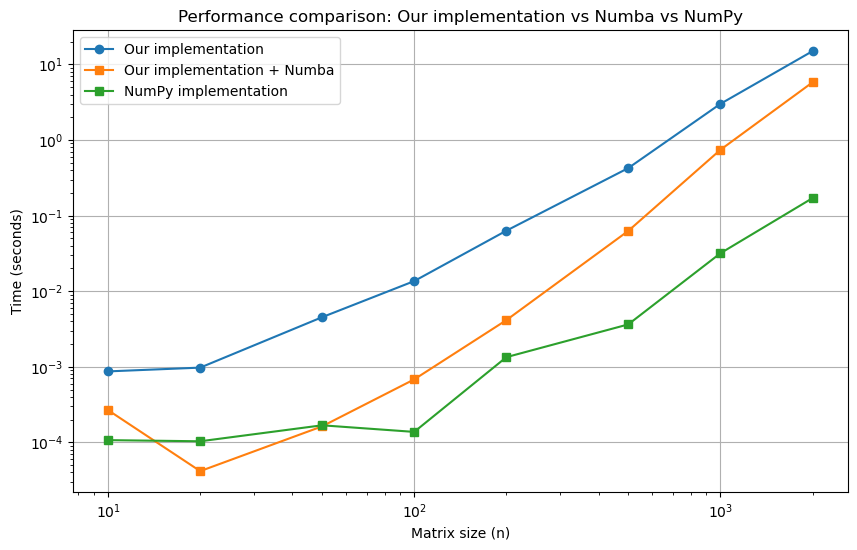

In [12]:
# Plot the performance comparison
ge_times = df['Time GE']
nu_times = df['Time Numba']
np_times = df['Time NumPy']

plt.figure(figsize=(10, 6))
plt.plot(sizes, ge_times, 'o-', label='Our implementation')
plt.plot(sizes, nu_times, 's-', label='Our implementation + Numba')
plt.plot(sizes, np_times, 's-', label='NumPy implementation')
plt.xlabel('Matrix size (n)')
plt.ylabel('Time (seconds)')
plt.title('Performance comparison: Our implementation vs Numba vs NumPy')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
#k, log_a = np.polyfit(np.log(sizes[2:]), np.log(ge_times[2:]), 1)
#plt.plot(sizes, np.exp(log_a)*sizes**k)

When data follows a straight line in a log-log plot, it indicates that the relationship between the two variables adheres to a *power law*. Specifically, the data can be modeled by an equation of the form 
$$y = ax^k.$$
To show that, take the logarithm of both sides of the power law equation transforms it into:
$$
   \log(y) = \log(a) + k\log(x).
$$
This is a linear equation where $k$ is the slope of the line and $\log(a)$ is the intercept.

In [13]:
k, log_a = np.polyfit(np.log(sizes[2:]), np.log(ge_times[2:]), 1)
print("k =", k)
print("a =", np.exp(log_a))

k = 2.231943052937099
a = 5.398901484683666e-07
